In [ ]:
from fl_puf.Utils.tabular_data_loader import prepare_tabular_data
from DPL.RegularizationLoss import RegularizationLoss
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
import torch 

In [ ]:
def get_disparity(client_data):
    clients_disparity = []
    client_names = []
    for client_name, client in enumerate(client_data):
        max_disparity = 0
        y = list(client['y'])
        z = list(client['z'])
        for target in [0,1]:
            for sensitive_value in [0,1]:
                max_disparity = max(RegularizationLoss().compute_violation_with_argmax(
                    predictions_argmax=y,
                    sensitive_attribute_list=z,
                    current_target=target,
                    current_sensitive_feature=sensitive_value,
                ), max_disparity)
        clients_disparity.append(max_disparity)
        client_names.append(client_name)
    return clients_disparity, client_names

In [ ]:
def get_disparity_node(y, z):
    max_disparity = 0
    for target in [0,1]:
        max_disparity = max(RegularizationLoss().compute_violation_with_argmax(
            predictions_argmax=list(y),
            sensitive_attribute_list=list(z),
            current_target=target,
            current_sensitive_feature=0,
        ), max_disparity)
    return max_disparity

In [ ]:
def find_disparity(groups_balance_factor, priv_balance_factor):
    fed_dir, client_data = prepare_tabular_data(dataset_path="../data/Tabular/dutch/", dataset_name="dutch", groups_balance_factor=groups_balance_factor, priv_balance_factor=priv_balance_factor)
    clients_disparity, clients_name = get_disparity(client_data)
    # plot the disparity for each client
    print(f"Current setup groups_balance_factor={groups_balance_factor}, priv_balance_factor={priv_balance_factor}")
    plt.figure(figsize=(20, 8))
    plt.bar(clients_name, clients_disparity)
    plt.xlabel("Client")
    plt.ylabel("Disparity")
    plt.title("Disparity per client")
    plt.show()
    return client_data

In [ ]:
client_data = find_disparity(groups_balance_factor=0.5, priv_balance_factor=0.9)

In [ ]:
test_nodes = ['15', '71', '0', '87', '19', '120', '85', '127', '32', '149', '38', '23', '126', '72', '7', '66', '2', '31', '128', '130', '89', '115', '131', '79', '36', '77', '81', '117', '140', '57', '53', '30', '139', '21', '138', '141', '142', '50', '78', '116', '12', '83', '56', '64', '24', '61', '92', '84', '34', '6'] 
test_nodes = [int(x) for x in test_nodes]

train_nodes = [x for x in range(150) if x not in test_nodes]

In [ ]:
y_z = [[(int(y), int(z)) for y, z in zip(client['y'], client['z'])] for client in client_data]

In [63]:
disparities = {}
for node in test_nodes:
    current_node = y_z[node]
    y = torch.tensor([y for y, z in current_node])
    z = torch.tensor([z for y, z in current_node])
    current_disparity = get_disparity_node(y, z)
    disparities[node] = current_disparity

disparities_train = {}
for node in train_nodes:
    current_node = y_z[node]
    y = torch.tensor([y for y, z in current_node])
    z = torch.tensor([z for y, z in current_node])
    current_disparity = get_disparity_node(y, z)
    disparities_train[node] = current_disparity



In [ ]:
len(disparities.values())

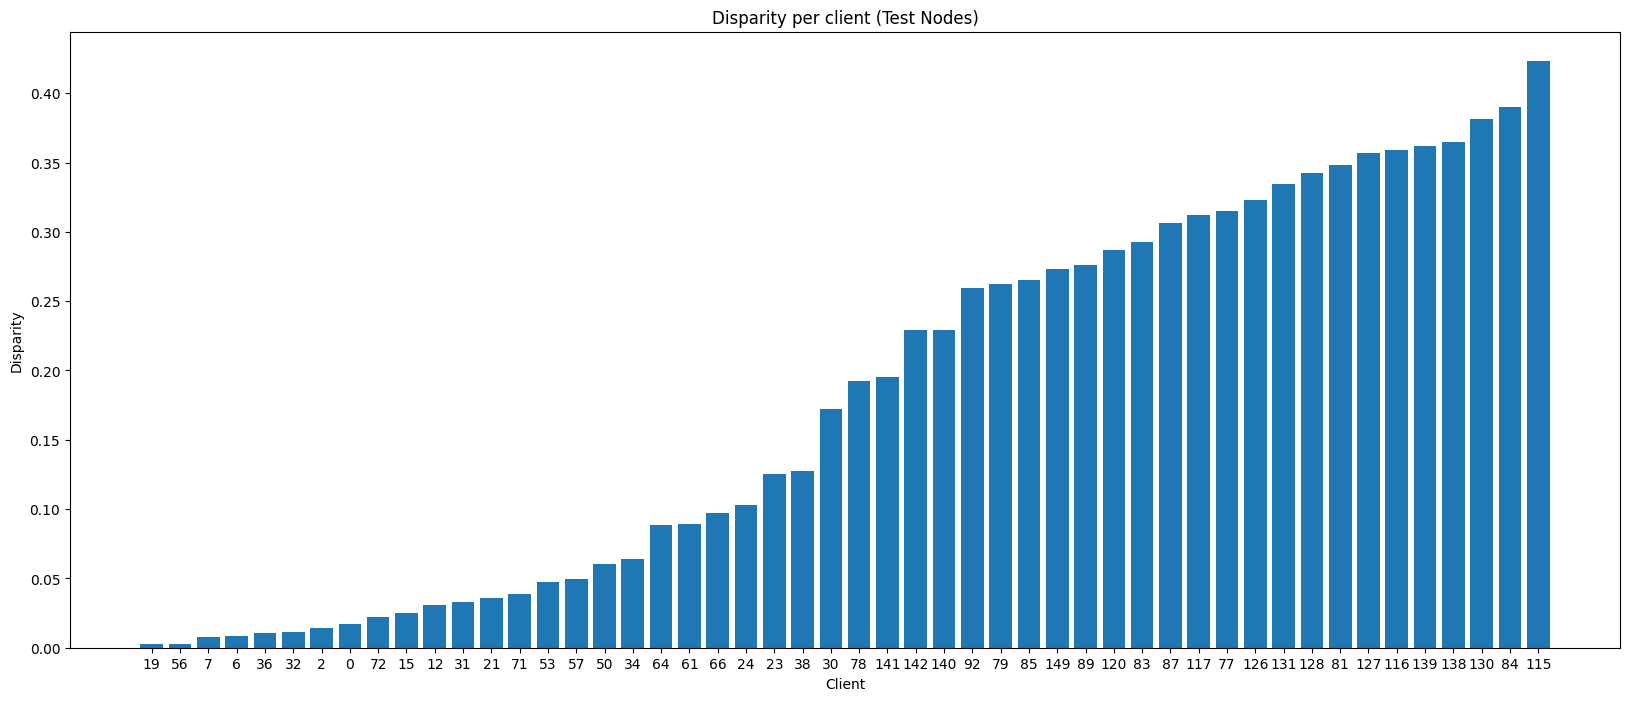

In [64]:
# sort the nodes by disparity
disparities = {k: v for k, v in sorted(disparities.items(), key=lambda item: item[1])}
disparities.values()

x = list(disparities.keys())
y = list(disparities.values())
# plot the disparity for each client without using the x values as 
# ticks but only as a name
plt.figure(figsize=(20, 8))
plt.bar(range(len(y)), y)
plt.xticks(range(len(x)), x)
plt.xlabel("Client")
plt.ylabel("Disparity")
plt.title("Disparity per client (Test Nodes)")
plt.show()


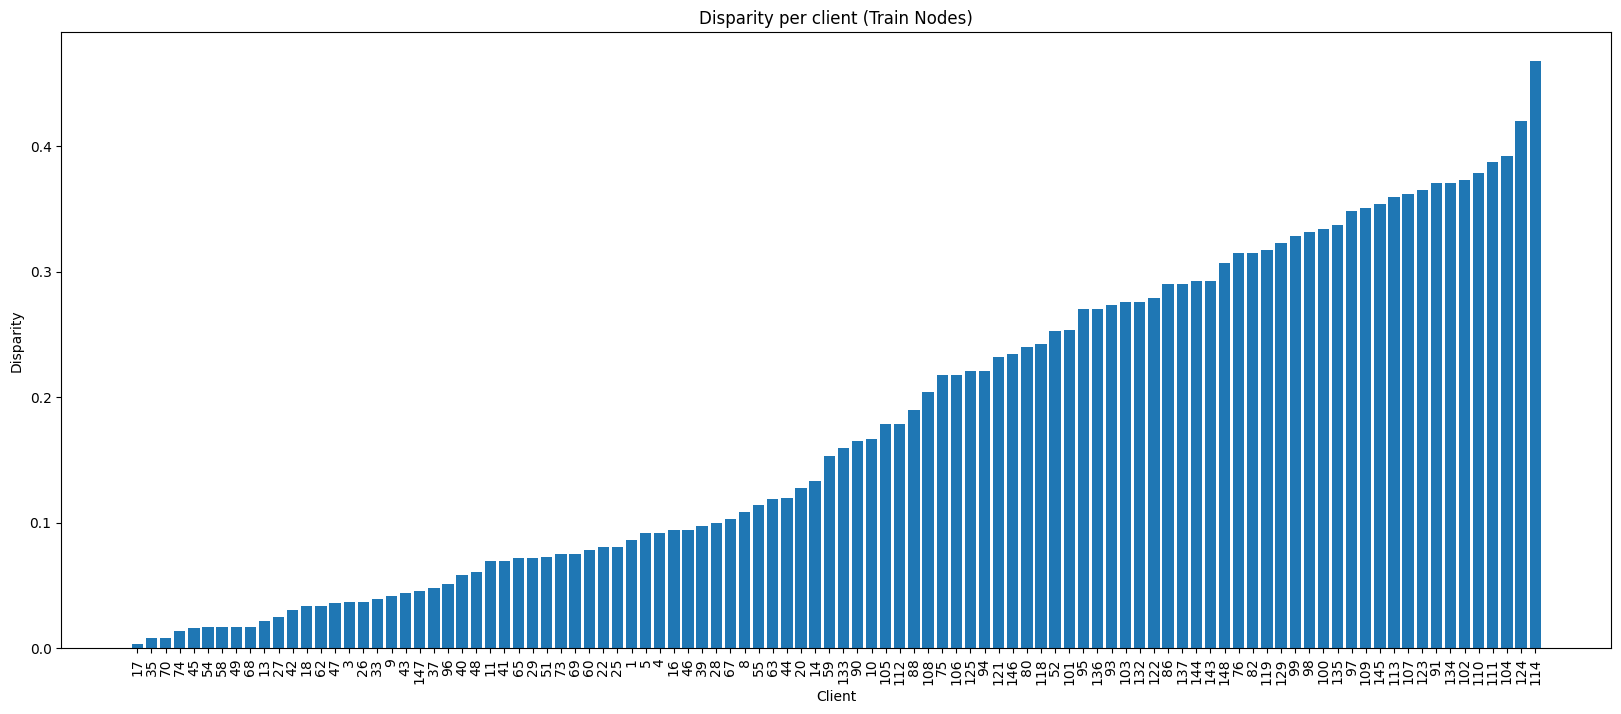

: 

In [67]:
# sort the nodes by disparity
disparities = {k: v for k, v in sorted(disparities_train.items(), key=lambda item: item[1])}
disparities.values()

x = list(disparities.keys())
y = list(disparities.values())
# plot the disparity for each client without using the x values as 
# ticks but only as a name
plt.figure(figsize=(20, 8))
plt.bar(range(len(y)), y)
plt.xticks(range(len(x)), x)
plt.xlabel("Client")
plt.ylabel("Disparity")
plt.xticks(rotation=90)
plt.title("Disparity per client (Train Nodes)")
plt.show()


In [ ]:
for group_balance in np.arange(0.1, 1.0, 0.1):
    for priv_balance in np.arange(0.5, 1.0, 0.1):
        find_disparity(groups_balance_factor=group_balance, priv_balance_factor=priv_balance)